In [209]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import LinearRegression,Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,GridSearchCV, cross_validate
from sklearn.metrics import r2_score as r2, mean_squared_error as mse
from sklearn.decomposition import PCA

In [210]:
data = pd.read_excel("/Users/adithya/Desktop/Materials/Books/Data-science/ML_Ankur/Dataset/proc1a.xlsx", skiprows=1,usecols="C:AI")

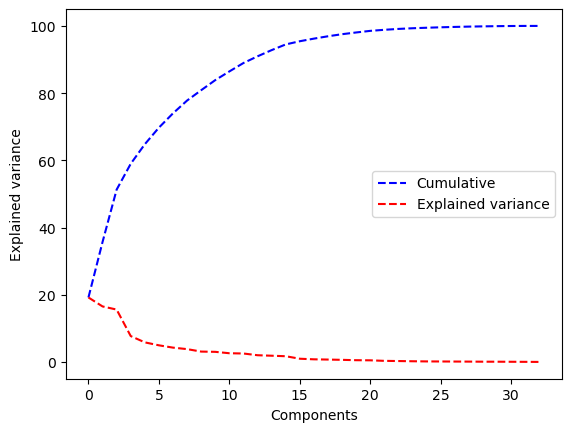

In [211]:
data_train=data.iloc[0:69]
scaler=StandardScaler()
pca=PCA()
data_train_normal=scaler.fit_transform(data_train)
pca_train=pca.fit_transform(data_train_normal)

explained_variance = 100 * pca.explained_variance_ratio_
cum_explained = np.cumsum(explained_variance)

plt.figure()
plt.plot(cum_explained,"b--",label="Cumulative")
plt.plot(explained_variance,"r--",label="Explained variance")
plt.xlabel("Components")
plt.ylabel("Explained variance")
plt.legend()

nc= np.argmax(cum_explained>=90) + 1
nc= np.argmax(cum_explained>=90) + 1
pca_train_reduced = pca_train[:,0:nc]


/var/folders/q9/5_nm2crd6bj1gg__mk24nv3m0000gn/T/ipykernel_18032/3932523817.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  theta2 = np.sum(eig_vals[j]**2 for j in range(k,m))
/var/folders/q9/5_nm2crd6bj1gg__mk24nv3m0000gn/T/ipykernel_18032/3932523817.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  theta3 = np.sum(eig_vals[j]**3 for j in range(k,m))


(Text(0.5, 0, 'Sample'), Text(0, 0.5, 'T2/Q for training data'))

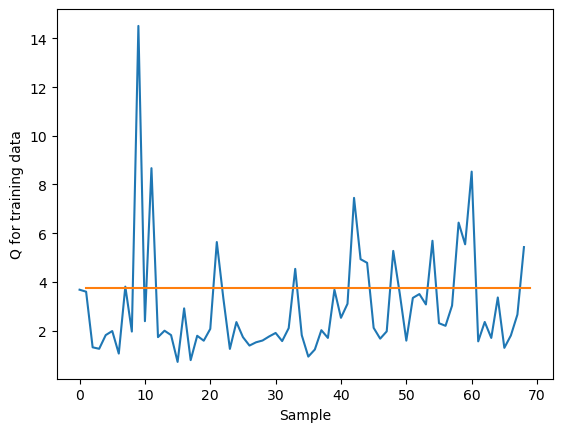

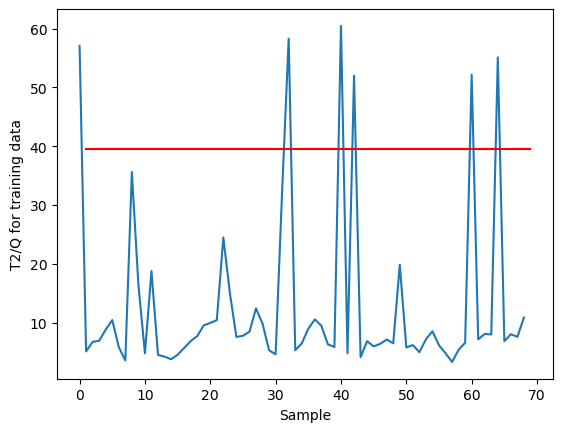

In [200]:


lambda_k=np.diag(pca.explained_variance_[0:nc])
lambda_k_inv=np.linalg.inv(lambda_k)

T2_train = np.zeros((data_train_normal.shape[0],))
for i in range (data_train_normal.shape[0]):
    T2_train[i]=np.dot(np.dot(lambda_k_inv,pca_train_reduced[i,:]),pca_train_reduced[i,:].T)

V_matrix = pca.components_.T
P_matrix = V_matrix[:,0:nc]

data_train_normal_reconstruct = np.dot(score_train_reduced, P_matrix.T)
error_train = data_train_normal - data_train_normal_reconstruct

Q_train = np.sum(error_train*error_train, axis=1)

N=data_train_normal_reconstruct.shape[0]
k=nc
alpha=0.01

import scipy.stats
T2_CL = k*(N**2-1)*scipy.stats.f.ppf(1-alpha,k,N-k)/(N*(N-k))

# ✅ T² finds unusual-but-still-normal points.
# ✅ Q finds weird, unpredictable, or faulty points.

m = data_train_normal.shape[1]
eig_vals = pca.explained_variance_

theta1 = np.sum(eig_vals[k:])
theta2 = np.sum(eig_vals[j]**2 for j in range(k,m))
theta3 = np.sum(eig_vals[j]**3 for j in range(k,m))

h0 = 1 -2*theta1*theta3/(3*theta2**2)

z_alpha =scipy.stats.norm.ppf(1-alpha)
Q_CL = theta1 *(z_alpha*np.sqrt(2*theta2*h0**2)/theta1+1+theta2*h0*(1-h0)/theta1**2)**2

plt.figure()
plt.plot(Q_train)
plt.plot([1,len(Q_train)],[Q_CL,Q_CL])
plt.xlabel("Sample"),plt.ylabel("Q for training data")

plt.figure()
plt.plot(T2_train)
plt.plot([1,len(T2_train)],[T2_CL,T2_CL], color='red')
plt.xlabel("Sample"),plt.ylabel("T2/Q for training data")


#Fault detection#

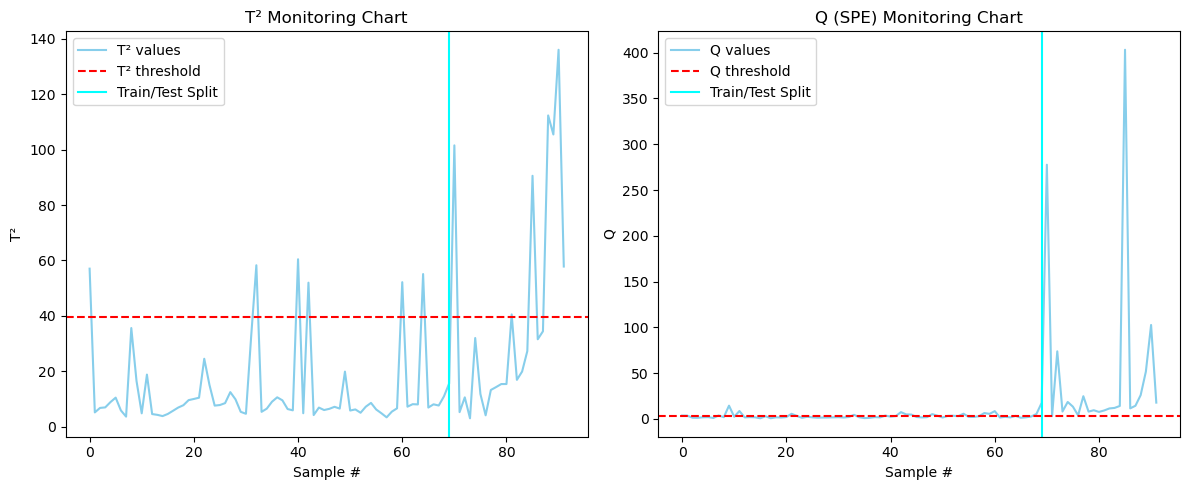

In [212]:
# ================================
# 1. LOAD & PREPROCESS DATA
# ================================

# Split your dataset (adjust as needed)
data_train = data.iloc[:69, :]
data_test = data.iloc[69:, :]

# Standardize (important for PCA!)
scaler = StandardScaler()
pca=PCA()

data_train_normal=scaler.fit_transform(data_train)
pca_train=pca.fit_transform(data_train_normal)

explained_variance = 100 * pca.explained_variance_ratio_
cum_explained = np.cumsum(explained_variance)

data_test_normal = scaler.transform(data_test)
explained_variance = 100 * pca.explained_variance_ratio_
cum_explained = np.cumsum(explained_variance)

nc= np.argmax(cum_explained>=90) + 1
pca_train_reduced = pca_train[:,0:nc]

# ================================
# 2. APPLY PCA TO TRAINING DATA
# ================================


score_train = pca.fit_transform(data_train_normal)
score_train_reduced = score_train[:, :nc]

# Get PCA loading/projection matrix
P_matrix = pca.components_.T[:, :nc]

# Reconstruct training data using top nc components
data_train_reconstruct = score_train_reduced @ P_matrix.T

# ================================
# 3. CALCULATE T² AND Q FOR TRAINING DATA
# ================================

# T² statistic: How far the point is from center in PCA space
lambda_k = np.diag(pca.explained_variance_[:nc])
lambda_k_inv = np.linalg.inv(lambda_k)
T2_train = np.array([
    score @ lambda_k_inv @ score.T for score in score_train_reduced
])

# Q statistic: What PCA failed to explain
error_train = data_train_normal - data_train_reconstruct
Q_train = np.sum(error_train ** 2, axis=1)

# ================================
# 4. CONTROL LIMITS FOR T² AND Q
# ================================

N = data_train.shape[0]
alpha = 0.01  # 99% confidence
m = data_train.shape[1]
eig_vals = pca.explained_variance_

# T² limit (F-distribution)
T2_CL = nc * (N**2 - 1) * scipy.stats.f.ppf(1 - alpha, nc, N - nc) / (N * (N - nc))

# Q (SPE) limit (Jackson's method)
theta1 = np.sum(eig_vals[nc:])
theta2 = np.sum([eig_vals[j]**2 for j in range(nc, m)])
theta3 = np.sum([eig_vals[j]**3 for j in range(nc, m)])
h0 = 1 - 2 * theta1 * theta3 / (3 * theta2**2)
z_alpha = scipy.stats.norm.ppf(1 - alpha)
Q_CL = theta1 * (
    z_alpha * np.sqrt(2 * theta2 * h0**2) / theta1 +
    1 + theta2 * h0 * (1 - h0) / theta1**2
)**2

# ================================
# 5. APPLY PCA TO TEST DATA
# ================================

score_test = pca.transform(data_test_normal)
score_test_reduced = score_test[:, :nc]
data_test_reconstruct = score_test_reduced @ P_matrix.T

# T² for test
T2_test = np.array([
    score @ lambda_k_inv @ score.T for score in score_test_reduced
])

# Q for test
error_test = data_test_normal - data_test_reconstruct
Q_test = np.sum(error_test ** 2, axis=1)

# ================================
# 6. PLOT MONITORING CHARTS (Train + Test)
# ================================

# Combine for unified chart
T2_all = np.concatenate([T2_train, T2_test])
Q_all = np.concatenate([Q_train, Q_test])
split_index = len(T2_train)

# T² Monitoring Chart
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(T2_all, label='T² values', color='skyblue')
plt.axhline(T2_CL, color='red', linestyle='--', label='T² threshold')
plt.axvline(split_index, color='cyan', linestyle='-', label='Train/Test Split')
plt.title("T² Monitoring Chart")
plt.xlabel("Sample #")
plt.ylabel("T²")
plt.legend()

# Q Monitoring Chart
plt.subplot(1, 2, 2)
plt.plot(Q_all, label='Q values', color='skyblue')
plt.axhline(Q_CL, color='red', linestyle='--', label='Q threshold')
plt.axvline(split_index, color='cyan', linestyle='-', label='Train/Test Split')
plt.title("Q (SPE) Monitoring Chart")
plt.xlabel("Sample #")
plt.ylabel("Q")
plt.legend()

plt.tight_layout()
plt.show()
